In [1]:
import json
import warnings
from pathlib import Path
from typing import Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # heatmap için

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from PIL import Image
from tqdm import tqdm

from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
warnings.filterwarnings("ignore")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")



Device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
proje_yolu = Path(r"C:\Users\PC\Desktop\deepCNN")

DATA_DIR  = proje_yolu / "data"
train_yol = DATA_DIR / "train"
test_yol  = DATA_DIR / "test"

model_yolu  = proje_yolu / "models"
output_yolu = proje_yolu / "outputs"
model_yolu.mkdir(parents=True, exist_ok=True)
output_yolu.mkdir(parents=True, exist_ok=True)

print("Proje:", proje_yolu)
print("Train:", train_yol)
print("Test :", test_yol)
print("Models:", model_yolu)
print("Outputs:", output_yolu)

if not train_yol.exists():
    raise FileNotFoundError(f"Train klasörü yok: {train_yol}")

HAS_TEST_FOLDER = test_yol.exists()
print("Test klasörü var mı? ->", HAS_TEST_FOLDER)


Proje: C:\Users\PC\Desktop\deepCNN
Train: C:\Users\PC\Desktop\deepCNN\data\train
Test : C:\Users\PC\Desktop\deepCNN\data\test
Models: C:\Users\PC\Desktop\deepCNN\models
Outputs: C:\Users\PC\Desktop\deepCNN\outputs
Test klasörü var mı? -> True


Train listeleniyor.
Test listeleniyor.
Toplam görsel: 185,015
Azaltılmış train ile yeni toplam: 84,255

Train dağılımı:
 class
AI      36755
REAL    17500
Name: count, dtype: int64

Test dağılımı:
 class
AI      20000
REAL    10000
Name: count, dtype: int64


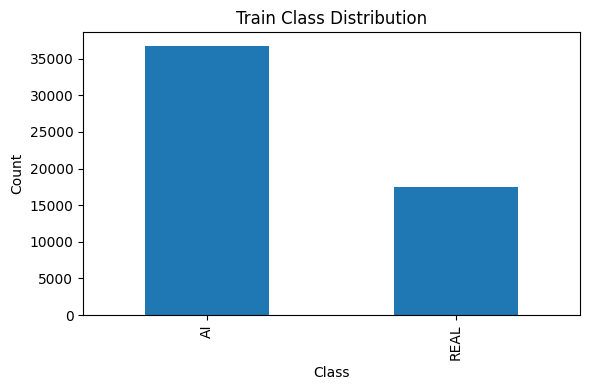

Kaydedildi: C:\Users\PC\Desktop\deepCNN\outputs\class_distribution.png


In [3]:
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def klasorden_veri_ekle(ana_klasor: Path, split_adi: str, liste: list):
    for cls_dir in ana_klasor.iterdir():
        if not cls_dir.is_dir():
            continue
        name = cls_dir.name.lower()

        if name.startswith("ai_"):
            label = 0
            cls = "AI"
        else:
            label = 1
            cls = "REAL"

        for f in cls_dir.glob("*"):
            if f.suffix.lower() in IMG_EXTS:
                liste.append({"path": str(f), "label": label, "class": cls, "split": split_adi})

data = []
print("Train listeleniyor.")
klasorden_veri_ekle(train_yol, "train", data)

if HAS_TEST_FOLDER:
    print("Test listeleniyor.")
    klasorden_veri_ekle(test_yol, "test", data)

df = pd.DataFrame(data)
print(f"Toplam görsel: {len(df):,}")

REDUCTION_RATE = 0.35   
if REDUCTION_RATE < 1.0:
    train_df0 = df[df["split"] == "train"].copy()
    test_df0  = df[df["split"] == "test"].copy() if HAS_TEST_FOLDER else pd.DataFrame(columns=df.columns)

    train_df0 = (
        train_df0.groupby("class", group_keys=False)
        .apply(lambda x: x.sample(frac=REDUCTION_RATE, random_state=SEED))
        .reset_index(drop=True)
    )

    df = pd.concat([train_df0, test_df0], ignore_index=True)
    print(f"Azaltılmış train ile yeni toplam: {len(df):,}")

train_df = df[df["split"] == "train"].copy()
test_df  = df[df["split"] == "test"].copy()

print("\nTrain dağılımı:\n", train_df["class"].value_counts())
if HAS_TEST_FOLDER and len(test_df) > 0:
    print("\nTest dağılımı:\n", test_df["class"].value_counts())

plt.figure(figsize=(6,4))
train_df["class"].value_counts().plot(kind="bar")
plt.title("Train Class Distribution")
plt.xlabel("Class"); plt.ylabel("Count")
plt.tight_layout()
plt.savefig(output_yolu / "class_distribution.png", dpi=200)
plt.show()
print("Kaydedildi:", output_yolu / "class_distribution.png")


In [4]:
IMAGE_SIZE = 224

class ArtworkDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = list(paths)
        self.labels = list(labels)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        y = int(self.labels[idx])
        if self.transform:
            img = self.transform(img)
        return img, y

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

print("Dataset + Transform hazır")


Dataset + Transform hazır


In [5]:
train_data = df[df["split"] == "train"].copy()
train_paths = train_data["path"].values
train_labels = train_data["label"].values

if HAS_TEST_FOLDER and len(test_df) > 0:
    test_paths = test_df["path"].values
    test_labels = test_df["label"].values

    train_paths_final, val_paths, train_labels_final, val_labels = train_test_split(
        train_paths, train_labels,
        test_size=0.15, random_state=SEED, stratify=train_labels
    )
else:
    train_paths_tmp, test_paths, train_labels_tmp, test_labels = train_test_split(
        train_paths, train_labels,
        test_size=0.15, random_state=SEED, stratify=train_labels
    )
    train_paths_final, val_paths, train_labels_final, val_labels = train_test_split(
        train_paths_tmp, train_labels_tmp,
        test_size=0.15, random_state=SEED, stratify=train_labels_tmp
    )

print(f"Train: {len(train_paths_final):,}")
print(f"Val  : {len(val_paths):,}")
print(f"Test : {len(test_paths):,}")

BATCH_SIZE = 32 if torch.cuda.is_available() else 16
NUM_WORKERS = 0  
PIN_MEMORY = True if torch.cuda.is_available() else False

train_loader = DataLoader(
    ArtworkDataset(train_paths_final, train_labels_final, train_transform),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)
val_loader = DataLoader(
    ArtworkDataset(val_paths, val_labels, test_transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)
test_loader = DataLoader(
    ArtworkDataset(test_paths, test_labels, test_transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)

print("DataLoader hazır:",
      f"train_batches={len(train_loader)}, val_batches={len(val_loader)}, test_batches={len(test_loader)}")


Train: 46,116
Val  : 8,139
Test : 30,000
DataLoader hazır: train_batches=1442, val_batches=255, test_batches=938


In [6]:
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        avg = self.avg_pool(x).view(b, c)
        mx  = self.max_pool(x).view(b, c)
        out = self.sigmoid(self.fc(avg) + self.fc(mx)).view(b, c, 1, 1)
        return x * out

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        mx, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg, mx], dim=1)
        out = self.sigmoid(self.conv(concat))
        return x * out

class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(channels, reduction)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x

print("CBAM hazır.")


CBAM hazır.


In [7]:
def _get_weights(model_key: str):
    try:
        if model_key == "eff":
            return models.EfficientNet_B0_Weights.DEFAULT
        if model_key == "dense":
            return models.DenseNet121_Weights.DEFAULT
    except Exception:
        return None
    return None

class ModelFactory:
    @staticmethod
    def create_model(model_name: str, pretrained=True, freeze_backbone=True):
        if model_name == "efficientnet_cbam":
            w = _get_weights("eff") if pretrained else None
            try:
                model = models.efficientnet_b0(weights=w)
            except TypeError:
                model = models.efficientnet_b0(pretrained=pretrained)

            num_features = model.classifier[1].in_features

            model.features.add_module("cbam", CBAM(num_features))

            model.classifier = nn.Sequential(
                nn.Dropout(0.25),
                nn.Linear(num_features, 1)
            )

        elif model_name == "densenet121":
            w = _get_weights("dense") if pretrained else None
            try:
                model = models.densenet121(weights=w)
            except TypeError:
                model = models.densenet121(pretrained=pretrained)

            num_features = model.classifier.in_features
            model.classifier = nn.Sequential(
                nn.Dropout(0.35),
                nn.Linear(num_features, 1)
            )

        else:
            raise ValueError("Model tanımlı değil!")

        if freeze_backbone:
            for p in model.parameters():
                p.requires_grad = False
            for p in model.classifier.parameters():
                p.requires_grad = True

            if model_name == "efficientnet_cbam":
                for p in model.features.cbam.parameters():
                    p.requires_grad = True

        return model

print("ModelFactory hazır.")


ModelFactory hazır.


In [8]:
def train_one_epoch(model, loader, criterion, optimizer, scaler=None):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in tqdm(loader, desc="Train", leave=False):
        x = x.to(device, non_blocking=True)
        y = torch.tensor(y, dtype=torch.float32, device=device)

        optimizer.zero_grad(set_to_none=True)

        if scaler is not None:
            with torch.cuda.amp.autocast():
                logits = model(x).view(-1)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(x).view(-1)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

        total_loss += loss.item()

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        total += y.numel()
        correct += (preds == y).sum().item()

    return total_loss / max(1, len(loader)), 100.0 * correct / max(1, total)

@torch.no_grad()
def validate_one_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in tqdm(loader, desc="Val", leave=False):
        x = x.to(device, non_blocking=True)
        y = torch.tensor(y, dtype=torch.float32, device=device)

        logits = model(x).view(-1)
        loss = criterion(logits, y)

        total_loss += loss.item()

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        total += y.numel()
        correct += (preds == y).sum().item()

    return total_loss / max(1, len(loader)), 100.0 * correct / max(1, total)

@torch.no_grad()
def evaluate_model(model, loader):
    model.eval()
    all_probs, all_preds, all_labels = [], [], []

    for x, y in tqdm(loader, desc="Evaluate", leave=False):
        x = x.to(device, non_blocking=True)
        logits = model(x).view(-1)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        preds = (probs > 0.5).astype(np.int32)

        all_probs.extend(probs.tolist())
        all_preds.extend(preds.tolist())
        all_labels.extend(list(map(int, y)))

    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    try:
        roc_auc = roc_auc_score(all_labels, all_probs)
    except Exception:
        roc_auc = float("nan")

    report = classification_report(
        all_labels, all_preds,
        target_names=["AI","REAL"],
        output_dict=True, zero_division=0
    )

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc,
        "labels": all_labels,
        "predictions": all_preds,
        "probabilities": all_probs,
        "class_report": report
    }

print("Train/Val/Eval fonksiyonları hazır")


Train/Val/Eval fonksiyonları hazır


In [9]:
results = {}

EPOCHS = 6
PATIENCE = 2
LR = 2e-4
WEIGHT_DECAY = 1e-4

use_amp = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler() if use_amp else None

try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

def train_and_save_one_model(model_name: str, freeze_backbone: bool = True):
    print("\n" + "="*90)
    print(f"TRAIN START: {model_name.upper()}")
    print("="*90)

    model = ModelFactory.create_model(
        model_name,
        pretrained=True,
        freeze_backbone=freeze_backbone
    ).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=LR, weight_decay=WEIGHT_DECAY
    )

    best_path = model_yolu / f"best_{model_name}.pth"
    last_path = model_yolu / f"last_{model_name}.pth"
    hist_path = output_yolu / f"history_{model_name}.json"
    eval_path = output_yolu / f"eval_{model_name}.json"

    best_val_loss = float("inf")
    patience_counter = 0
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    try:
        for epoch in range(EPOCHS):
            print(f"\nEpoch [{epoch+1}/{EPOCHS}]")

            train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler=scaler)
            val_loss, val_acc     = validate_one_epoch(model, val_loader, criterion)

            history["train_loss"].append(float(train_loss))
            history["val_loss"].append(float(val_loss))
            history["train_acc"].append(float(train_acc))
            history["val_acc"].append(float(val_acc))

            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
            print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")

            torch.save(model.state_dict(), last_path)

            with open(hist_path, "w", encoding="utf-8") as f:
                json.dump(history, f, indent=2, ensure_ascii=False)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), best_path)
                print("💾 Best model kaydedildi:", best_path.name)
            else:
                patience_counter += 1
                if patience_counter >= PATIENCE:
                    print("Early stopping")
                    break

    except Exception as e:
        print("\nEğitim sırasında hata oldu ama last checkpoint kaydedildi:", last_path.name)
        print("Hata:", repr(e))

        del model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        raise

    model.load_state_dict(torch.load(best_path, map_location=device))
    model.eval()

    test_res = evaluate_model(model, test_loader)
    test_res["history"] = history
    results[model_name] = test_res

    safe_eval = {
        "accuracy": float(test_res["accuracy"]),
        "precision": float(test_res["precision"]),
        "recall": float(test_res["recall"]),
        "f1": float(test_res["f1"]),
        "roc_auc": float(test_res["roc_auc"]) if test_res["roc_auc"] == test_res["roc_auc"] else None
    }
    with open(eval_path, "w", encoding="utf-8") as f:
        json.dump(safe_eval, f, indent=2, ensure_ascii=False)

    print(f"\n BİTTİ: {model_name.upper()}")
    print(f"Test Acc: {test_res['accuracy']*100:.2f}% | F1: {test_res['f1']:.4f} | ROC-AUC: {test_res['roc_auc']:.4f}")
    print("Best:", best_path.name, "| Last:", last_path.name)
    print("Eval JSON:", eval_path.name, "| History JSON:", hist_path.name)

    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


In [10]:
train_and_save_one_model("efficientnet_cbam", freeze_backbone=True)



TRAIN START: EFFICIENTNET_CBAM

Epoch [1/6]


Train Loss: 0.3435 | Train Acc: 86.26%
Val   Loss: 0.2058 | Val   Acc: 93.24%
💾 Best model kaydedildi: best_efficientnet_cbam.pth

Epoch [2/6]


Train Loss: 0.2043 | Train Acc: 92.35%
Val   Loss: 0.1498 | Val   Acc: 95.15%
💾 Best model kaydedildi: best_efficientnet_cbam.pth

Epoch [3/6]


Train Loss: 0.1718 | Train Acc: 93.58%
Val   Loss: 0.1375 | Val   Acc: 95.16%
💾 Best model kaydedildi: best_efficientnet_cbam.pth

Epoch [4/6]


Train Loss: 0.1489 | Train Acc: 94.50%
Val   Loss: 0.1229 | Val   Acc: 95.69%
💾 Best model kaydedildi: best_efficientnet_cbam.pth

Epoch [5/6]


Train Loss: 0.1379 | Train Acc: 94.80%
Val   Loss: 0.1013 | Val   Acc: 96.66%
💾 Best model kaydedildi: best_efficientnet_cbam.pth

Epoch [6/6]


Train Loss: 0.1268 | Train Acc: 95.28%
Val   Loss: 0.0969 | Val   Acc: 96.65%
💾 Best model kaydedildi: best_efficientnet_cbam.pth



 BİTTİ: EFFICIENTNET_CBAM
Test Acc: 96.62% | F1: 0.9485 | ROC-AUC: 0.9938
Best: best_efficientnet_cbam.pth | Last: last_efficientnet_cbam.pth
Eval JSON: eval_efficientnet_cbam.json | History JSON: history_efficientnet_cbam.json


In [11]:
train_and_save_one_model("densenet121", freeze_backbone=True)



TRAIN START: DENSENET121
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\PC/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:08<00:00, 3.81MB/s]



Epoch [1/6]


Train Loss: 0.4403 | Train Acc: 80.47%
Val   Loss: 0.3178 | Val   Acc: 89.24%
💾 Best model kaydedildi: best_densenet121.pth

Epoch [2/6]


Train Loss: 0.3335 | Train Acc: 86.32%
Val   Loss: 0.2634 | Val   Acc: 90.96%
💾 Best model kaydedildi: best_densenet121.pth

Epoch [3/6]


Train Loss: 0.3111 | Train Acc: 87.29%
Val   Loss: 0.2338 | Val   Acc: 92.19%
💾 Best model kaydedildi: best_densenet121.pth

Epoch [4/6]


Train Loss: 0.3022 | Train Acc: 87.43%
Val   Loss: 0.2259 | Val   Acc: 92.41%
💾 Best model kaydedildi: best_densenet121.pth

Epoch [5/6]


Train Loss: 0.3009 | Train Acc: 87.43%
Val   Loss: 0.2159 | Val   Acc: 92.30%
💾 Best model kaydedildi: best_densenet121.pth

Epoch [6/6]


Train Loss: 0.2992 | Train Acc: 87.42%
Val   Loss: 0.2120 | Val   Acc: 92.69%
💾 Best model kaydedildi: best_densenet121.pth



 BİTTİ: DENSENET121
Test Acc: 92.93% | F1: 0.8877 | ROC-AUC: 0.9772
Best: best_densenet121.pth | Last: last_densenet121.pth
Eval JSON: eval_densenet121.json | History JSON: history_densenet121.json


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,EFFICIENTNET CBAM,0.966167,0.962239,0.9352,0.948527,0.993819
1,DENSENET121,0.929333,0.943694,0.8380,0.887712,0.977214


Kaydedildi: C:\Users\PC\Desktop\deepCNN\outputs\tablo1_genel_karsilastirma.xlsx


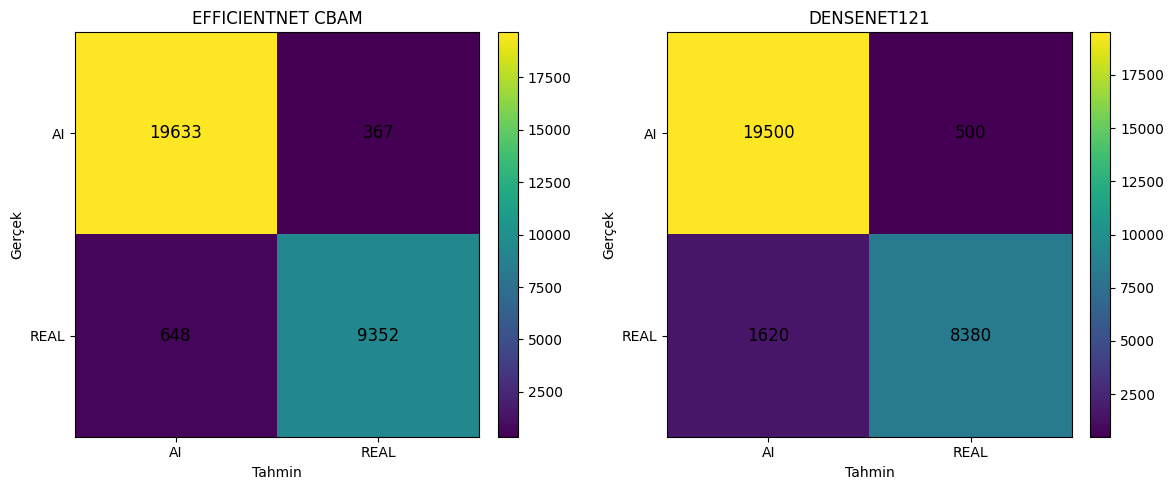

Kaydedildi: C:\Users\PC\Desktop\deepCNN\outputs\confusion_matrices.png


In [12]:
if "results" not in globals() or len(results) == 0:
    raise NameError("results boş. Önce model train hücrelerinden en az birini çalıştırmalısın.")

comparison_data = []
for model_name, res in results.items():
    comparison_data.append({
        "Model": model_name.upper().replace("_"," "),
        "Accuracy": res["accuracy"],
        "Precision": res["precision"],
        "Recall": res["recall"],
        "F1": res["f1"],
        "ROC_AUC": res["roc_auc"]
    })

df_comparison = pd.DataFrame(comparison_data)
display(df_comparison)
df_comparison.to_excel(output_yolu / "tablo1_genel_karsilastirma.xlsx", index=False)
print("Kaydedildi:", output_yolu / "tablo1_genel_karsilastirma.xlsx")

n = len(results)
fig, axes = plt.subplots(1, n, figsize=(6*n, 5))
if n == 1:
    axes = [axes]

for ax, (model_name, res) in zip(axes, results.items()):
    cmx = confusion_matrix(res["labels"], res["predictions"])
    im = ax.imshow(cmx)

    ax.set_title(model_name.upper().replace("_"," "))
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(["AI", "REAL"])
    ax.set_yticklabels(["AI", "REAL"])
    ax.set_xlabel("Tahmin")
    ax.set_ylabel("Gerçek")

    for (r, c), v in np.ndenumerate(cmx):
        ax.text(c, r, str(v), ha="center", va="center", color="black", fontsize=12)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(output_yolu / "confusion_matrices.png", dpi=200)
plt.show()
print("Kaydedildi:", output_yolu / "confusion_matrices.png")


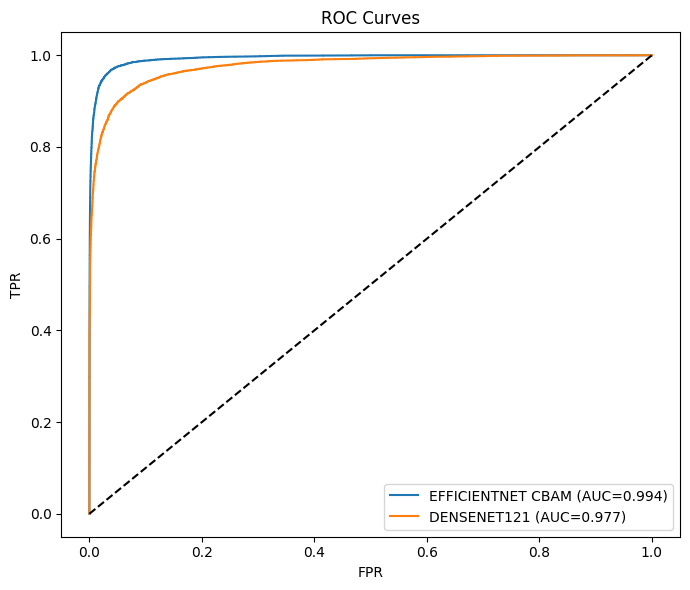

Kaydedildi: C:\Users\PC\Desktop\deepCNN\outputs\roc_curves.png


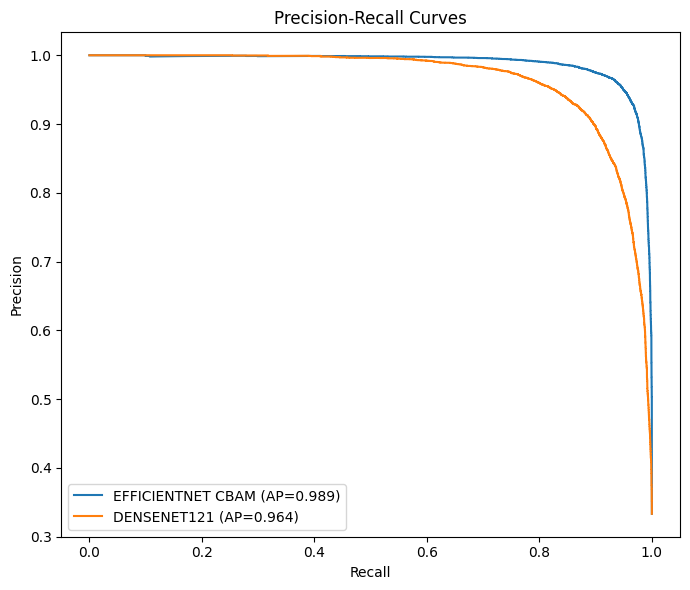

Kaydedildi: C:\Users\PC\Desktop\deepCNN\outputs\pr_curves.png


In [14]:
if "results" not in globals() or len(results) == 0:
    raise NameError("results boş.")

plt.figure(figsize=(7,6))
any_plotted = False
for model_name, res in results.items():
    y_true = np.array(res["labels"])
    y_prob = np.array(res["probabilities"])

    try:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = res.get("roc_auc", float("nan"))
        plt.plot(fpr, tpr, label=f"{model_name.upper().replace('_',' ')} (AUC={auc:.3f})")
        any_plotted = True
    except Exception as e:
        print(f"ROC çizilemedi ({model_name}):", repr(e))

plt.plot([0,1],[0,1],"k--")
plt.title("ROC Curves")
plt.xlabel("FPR"); plt.ylabel("TPR")
if any_plotted:
    plt.legend()
plt.tight_layout()
plt.savefig(output_yolu / "roc_curves.png", dpi=200)
plt.show()
print("Kaydedildi:", output_yolu / "roc_curves.png")

plt.figure(figsize=(7,6))
any_plotted = False
for model_name, res in results.items():
    y_true = np.array(res["labels"])
    y_prob = np.array(res["probabilities"])
    try:
        prec, rec, _ = precision_recall_curve(y_true, y_prob)
        ap = average_precision_score(y_true, y_prob)
        plt.plot(rec, prec, label=f"{model_name.upper().replace('_',' ')} (AP={ap:.3f})")
        any_plotted = True
    except Exception as e:
        print(f"PR çizilemedi ({model_name}):", repr(e))

plt.title("Precision-Recall Curves")
plt.xlabel("Recall"); plt.ylabel("Precision")
if any_plotted:
    plt.legend()
plt.tight_layout()
plt.savefig(output_yolu / "pr_curves.png", dpi=200)
plt.show()
print("Kaydedildi:", output_yolu / "pr_curves.png")


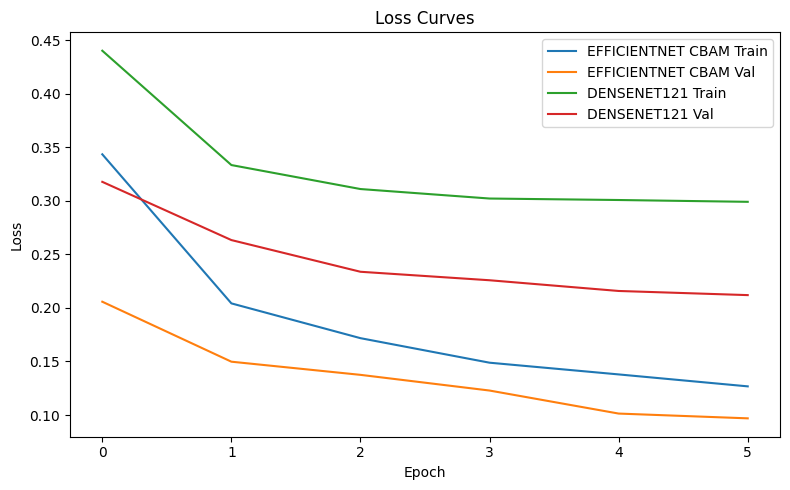

Kaydedildi: C:\Users\PC\Desktop\deepCNN\outputs\loss_curves.png


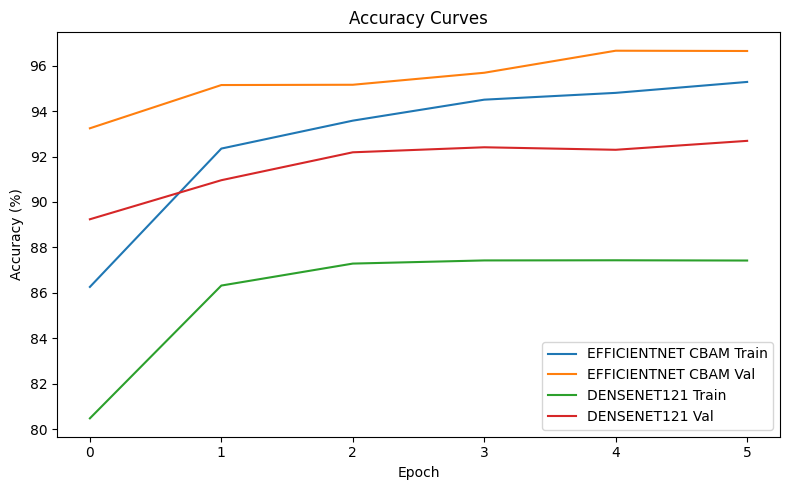

Kaydedildi: C:\Users\PC\Desktop\deepCNN\outputs\acc_curves.png


In [15]:
if "results" not in globals() or len(results) == 0:
    raise NameError("results boş.")

plt.figure(figsize=(8,5))
for model_name, res in results.items():
    hist = res.get("history", None)
    if not hist:
        print(f"history yok: {model_name} (train_and_save_one_model içinde history tutulduysa gelir)")
        continue
    plt.plot(hist["train_loss"], label=f"{model_name.upper().replace('_',' ')} Train")
    plt.plot(hist["val_loss"],   label=f"{model_name.upper().replace('_',' ')} Val")

plt.title("Loss Curves")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig(output_yolu / "loss_curves.png", dpi=200)
plt.show()
print("Kaydedildi:", output_yolu / "loss_curves.png")

plt.figure(figsize=(8,5))
for model_name, res in results.items():
    hist = res.get("history", None)
    if not hist:
        continue
    plt.plot(hist["train_acc"], label=f"{model_name.upper().replace('_',' ')} Train")
    plt.plot(hist["val_acc"],   label=f"{model_name.upper().replace('_',' ')} Val")

plt.title("Accuracy Curves")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
plt.legend()
plt.tight_layout()
plt.savefig(output_yolu / "acc_curves.png", dpi=200)
plt.show()
print("Kaydedildi:", output_yolu / "acc_curves.png")

In [16]:
if "results" not in globals() or len(results) == 0:
    raise NameError("results boş.")

best_name, best_res = max(results.items(), key=lambda x: x[1]["f1"])

print("EN İYİ MODEL:", best_name.upper().replace("_"," "))
print(f"Accuracy: {best_res['accuracy']*100:.2f}%")
print(f"F1      : {best_res['f1']:.4f}")
print(f"ROC-AUC : {best_res['roc_auc']:.4f}")

summary = {
    "best_model": best_name,
    "models": {
        k: {
            "accuracy": float(v["accuracy"]),
            "precision": float(v["precision"]),
            "recall": float(v["recall"]),
            "f1": float(v["f1"]),
            "roc_auc": (float(v["roc_auc"]) if v["roc_auc"] == v["roc_auc"] else None)
        } for k, v in results.items()
    }
}

with open(output_yolu / "results_summary.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print("Kaydedildi:", output_yolu / "results_summary.json")


EN İYİ MODEL: EFFICIENTNET CBAM
Accuracy: 96.62%
F1      : 0.9485
ROC-AUC : 0.9938
Kaydedildi: C:\Users\PC\Desktop\deepCNN\outputs\results_summary.json


In [20]:
from pathlib import Path

models_dir = Path.cwd().parent / "models"   
print("models_dir:", models_dir.resolve())

for fn in ["best_efficientnet_cbam.pth", "best_densenet121.pth", "best_resnet50_model.pth"]:
    print(fn, "->", (models_dir / fn).exists())



models_dir: C:\Users\PC\Desktop\deepCNN\models
best_efficientnet_cbam.pth -> True
best_densenet121.pth -> True
best_resnet50_model.pth -> True
